# RESEARCH QUESTION 1 - OUTPUT ANALYSIS

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import csv
from collections import Counter
from config import *
import math

## 1. LOAD DATA

In [2]:
%%time

with open("data/tweets.json", "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

Wall time: 24min 26s


In [3]:
%%time
df_tweets = pd.DataFrame.from_records(data)

Wall time: 10min 50s


In [4]:
df_tweets.shape

(500526, 37)

Sample of the tweets

In [5]:
df_tweets_100 = df_tweets[:100000]

Remove tweets that are not original, i.e. retweets.

In [6]:
tweets = df_tweets_100[df_tweets_100['retweeted_status'].isnull()].reset_index()
tweets.shape

(31916, 38)

Remove duplicates

In [7]:
tweets.drop_duplicates(subset = "id", keep = False, inplace = True) 
tweets.shape

(31914, 38)

For all the tweets that were retweets get the underlying original tweet

In [8]:
retweets = df_tweets_100[~df_tweets_100['retweeted_status'].isnull()]
retweets.shape

(68084, 37)

In [9]:
original = pd.DataFrame(list(retweets['retweeted_status'].values))
original.shape

(68084, 36)

In [10]:
tweets = pd.concat([tweets, original])

In [11]:
tweets = tweets.reset_index()
tweets.drop(columns = 'index', inplace = True)

In [12]:
tweets.drop_duplicates(subset = "id", keep = False, inplace = True) 
tweets.shape

(36623, 39)

In [13]:
tweets = tweets.reset_index()
tweets.drop(columns = ['index', 'level_0'], inplace = True)

## 2. PREPROCESS TEXT

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\99per\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
import re
from array import array
from numpy import linalg as la

In [16]:
def getTerms(text):
    """
    Preprocess the tweet text removing stop words, stemming, transforming to lowercase and return the tokens of 
    the text.
    
    Argument:
    text -- string (tweet) to be preprocessed
    
    Returns:
    text - a list of tokens (words) corresponding to the input tweet after the preprocessing
    """
    
    ## Remove Emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    ## Remove "RT"
    text = text.replace("RT ", "")
     
    ## Remove URLs, webpages
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    
    ## Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    ## Transform in lowercase
    text =  text.lower()

    ## Tokenize the text to get a list of terms
    text = text.split() 

    ## Remove stopwords
    stops = set(stopwords.words("english"))    
    text = [word for word in text if not word in stops] 
    
    ## Perform stemming
    stemming = PorterStemmer()
    text = [stemming.stem(word) for word in text] 
    
    return text

## 3. RANKING SCORE TF-IDF

Search engine based on the tweet text data.

In [17]:
def create_index_tfidf(ids, tweets, numDocuments):
    """
    Implement the inverted index for the tweet text and compute the tf, df and idf scores
    
    Argument:
    ids -- tweet ids of the corresponding tweets
    tweets -- collection of tweets
    numDocuments -- total number of tweets
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    
    tf - normalized term frequency for each term in each document
    
    df - number of documents each term appear in
    
    idf - inverse document frequency of each term
    """
        
    index = defaultdict(list)
    tf = defaultdict(list)        # term frequencies of terms in documents 
    df = defaultdict(int)         #document frequencies of terms in the corpus
    idf = defaultdict(float)
    
    for i in range(0, len(tweets)): 
        ## ===============================================================        
        ## create the index for the current doc and store it in termdictPage
        ## termdictPage ==> { ‘term1’: [currentdoc, [list of positions]], ..., ‘termn’: 
        ##                    [currentdoc, [list of positions]]}
        ## ===============================================================
        
        tweet = tweets[i]
        page_id = ids[i]
        
        termdictPage = {}
        
        terms = getTerms(tweet)
        
        ## Iterate over all terms in the tweet
        for position, term in enumerate(terms): 
            try:
                # if the term is already in the index for the current page (termdictPage)
                # append the position to the corresponding list
                termdictPage[term][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term] = [page_id, array('I', [position])]
            
        ## Merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage[0])
        
        # normalize term frequencies
        # Compute the denominator to normalize term frequencies
        # norm is the same for all terms of a document.
        norm = 0
        
        for term, posting in termdictPage.items(): 
            # posting is a list containing doc_id and the list of positions for current term in current document: 
            # posting ==> [currentdoc, [list of positions]] 
            norm += len(posting[1])**2
            
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():     
            
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm, 4))  
            
            # increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1  # increment df for current term
            
    # Compute idf 
    for term in df:
        idf[term] = np.round(np.log(float(numDocuments/df[term])), 4)
            
    return index, tf, df, idf

In [18]:
%%time
numDocuments = len(tweets)
index, tf, df, idf = create_index_tfidf(tweets['id'], tweets['text'], numDocuments)

Wall time: 29.6 s


## 4. SELECT QUERIES TO RUN

Display the words with highest idf, highest word frequency and highest document frequency.

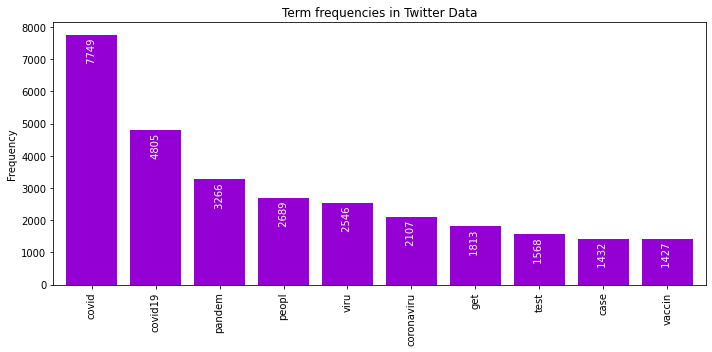

In [19]:
bag_of_words = {}

for text in tweets["text"]:
     
    lst_text = getTerms(text)
    
    # create bag-of-words - for each word the frequency of the word in the corpus
    for word in lst_text:
        if word not in bag_of_words:
            bag_of_words[word] = 0
        bag_of_words[word] += 1
        
sorted_dict = {}
sorted_keys = sorted(bag_of_words, key = bag_of_words.get, reverse = True)

for w in sorted_keys:
    sorted_dict[w] = bag_of_words[w]
    
most_freq = 10 
top = dict(list(sorted_dict.items())[:most_freq])

y = [count for tag, count in top.items()]
x = [tag for tag, count in top.items()]

plt.figure(figsize = (10, 5))
plt.bar(x, y, color = "darkviolet")
plt.title("Term frequencies in Twitter Data")
plt.ylabel("Frequency")
plt.xticks(rotation = 90)
for i, tag in enumerate(top):
    plt.text(i, y[i], f" {y[i]} ", rotation = 90, ha = "center", va = "top" if i < 10 else "bottom", 
             color = "white" if i < 10 else "black")
plt.xlim(-0.6, len(x)-0.4) 
plt.tight_layout()
plt.show()

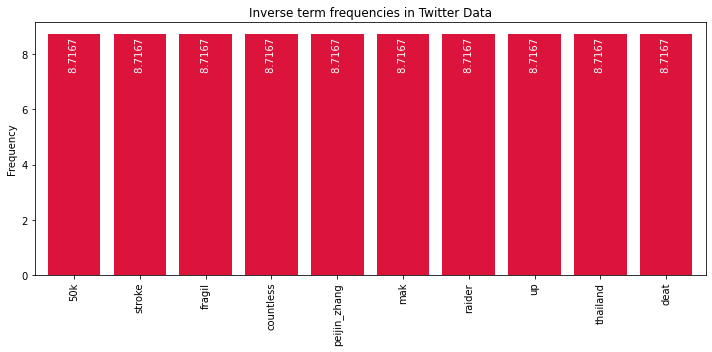

In [20]:
# Words that appear in more than one document 
df_filtered = {k: v for k, v in df.items() if v > 5}

# Words with idf in more than one document
idf_filtered = {k: v for k, v in idf.items() if k in df_filtered}

sorted_idf = {}
sorted_keys = sorted(idf_filtered, key = idf.get, reverse = True)

for w in sorted_keys:
    sorted_idf[w] = idf_filtered[w]
        
most_freq = 10 
top_idf = dict(list(sorted_idf.items())[:most_freq])

y = [count for tag, count in top_idf.items()]
x = [tag for tag, count in top_idf.items()]

plt.figure(figsize = (10, 5))
plt.bar(x, y, color = "crimson")
plt.title("Inverse term frequencies in Twitter Data")
plt.ylabel("Frequency")
plt.xticks(rotation = 90)
for i, tag in enumerate(top_idf):
    plt.text(i, y[i], f" {y[i]} ", rotation = 90, ha = "center", va = "top" if i < 10 else "bottom", 
             color = "white" if i < 10 else "black")
plt.xlim(-0.6, len(x)-0.4) 
plt.tight_layout()
plt.show()

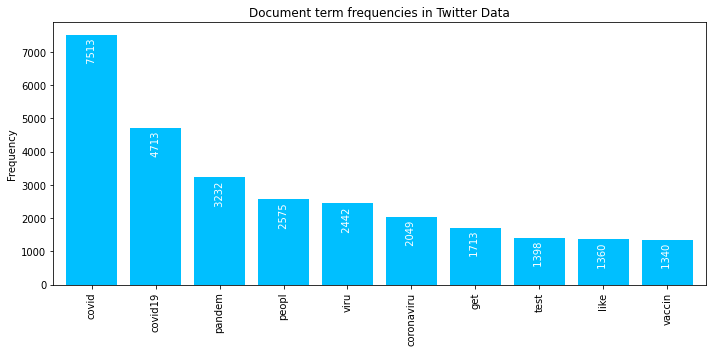

In [21]:
sorted_df = {}
sorted_keys = sorted(df, key = df.get, reverse = True)

for w in sorted_keys:
    sorted_df[w] = df[w]
        
most_freq = 10 
top_df = dict(list(sorted_df.items())[:most_freq])

y = [count for tag, count in top_df.items()]
x = [tag for tag, count in top_df.items()]

plt.figure(figsize = (10, 5))
plt.bar(x, y, color = "deepskyblue")
plt.title("Document term frequencies in Twitter Data")
plt.ylabel("Frequency")
plt.xticks(rotation = 90)
for i, tag in enumerate(top_df):
    plt.text(i, y[i], f" {y[i]} ", rotation = 90, ha = "center", va = "top" if i < 10 else "bottom", 
             color = "white" if i < 10 else "black")
plt.xlim(-0.6, len(x)-0.4) 
plt.tight_layout()
plt.show()

## 5. RANK DOCUMENTS ACCORDING TO TF-IDF

In [22]:
def rankDocuments(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    
    Returns:
    Print the list of ranked documents
    """
        
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors = defaultdict(lambda: [0]*len(terms)) 
    queryVector = [0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = Counter(terms) # get the frequency of each term in the query. 
    
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex] = query_terms_count[term]/query_norm * idf[term]

        # Generate docVectors for matching docs
        for docIndex, doc in enumerate(index[term]):    
            if doc in docs:
                docVectors[doc][termIndex] = tf[term][docIndex] * idf[term]

    # calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    docScores = [[np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items()]
    docScores.sort(reverse = True)
    resultDocs = [x[1] for x in docScores]
    
    #print document titles instead of document id's
    #resultDocs = [ titleIndex[x] for x in resultDocs ]
    if len(resultDocs) == 0:
        print("No results found, try again")
        print("Query: ", query)
        #query = input()
        #docs = search_tf_idf(query, index)    
    
    return resultDocs

In [23]:
def search_tf_idf(query, index):
    '''
    Outputs the list of documents that contain all of the query terms. 
    
    Argument:
    query -- list of query terms
    index -- inverted index data structure
    
    Returns:
    Return the list of top 10 documents
    
    '''
    query = getTerms(query)
    docs = set()
    
    # Return docs that contain all query terms
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs = [posting for posting in index[term]]

            # No documents had been stored yet
            if len(docs) == 0:
                docs = docs.union(termDocs)
            
            # Store only documents that are in both sets, meaning that they contained previous terms and current term
            else:
                docs = docs.intersection(termDocs)

        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf)   
    return ranked_docs

In [1]:
def add_query_results(tweets, docs, query):
    i = 1
    
    result = pd.DataFrame(columns = ['Query', 'Result', 'Tweet', 'User', 'Date', 'Hashtags', 'Likes', 'Retweets'])
    for doc_id in docs:
        tweet = tweets[tweets['id'] == doc_id]        
        user = tweet['user'].item()
        entities = tweet['entities'].item()
        hashtags = [hashtag['text'] for hashtag in entities['hashtags']]
        
        result = result.append({'Query': query, 'Result': i, 'Tweet': tweet['text'].item(), 'User': user['screen_name'], 
                                'Date': tweet['created_at'].item(), 'Hashtags': hashtags, 
                                'Likes': tweet['favorite_count'].item(),'Retweets': tweet['retweet_count'].item()}, 
                               ignore_index = True)
        i = i + 1
        
    return result

In [2]:
queries = ["covid", "pandemic", "people", "vaccine", "virus", "test", "stroke", "fragile", "countless", "thailand"]
results_tfidf = pd.DataFrame()
top = 20

for query in queries:
    ranked_docs = search_tf_idf(query, index)
    results_tfidf = results_tfidf.append(add_query_results(tweets, ranked_docs[:top], query), ignore_index = True)

NameError: name 'pd' is not defined

In [26]:
results_tfidf.shape

(144, 8)

In [27]:
results_tfidf.to_csv("top20_tfidf.tsv", sep = "\t")

## 6. SEARCH WORD2VEC

In [28]:
def create_index(ids, tweets, numDocuments):
    """
    Implement the inverted index for the tweet text and compute the word2vec score
    
    Argument:
    ids -- tweet ids of the corresponding tweets
    tweets -- collection of tweets
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    """
        
    index = defaultdict(list)
    
    for i in range(0, len(tweets)): 
            
        ## ===============================================================        
        ## create the index for the current doc and store it in termdictPage
        ## termdictPage ==> { ‘term1’: [currentdoc, [list of positions]], ..., ‘termn’: 
        ##                   [currentdoc, [list of positions]]}
        ## ===============================================================
        
        tweet = tweets[i]
        page_id = ids[i]
        
        termdictPage = {}
        
        terms = getTerms(tweet)
        
        ## Iterate over all terms in the tweet
        for position, term in enumerate(terms): 
            try:
                # if the term is already in the index for the current page (termdictPage)
                # append the position to the corresponding list
                termdictPage[term][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term] = [page_id, array('I', [position])]
            
        ## Merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage[0])
            
    return index

In [29]:
%%time
numDocuments = len(tweets)
index = create_index(tweets['id'], tweets['text'], numDocuments)

Wall time: 25.1 s


In [30]:
words = [getTerms(tweet) for tweet in tweets['text'].values]

In [31]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences = words, size = 100, window = 10, min_count = 1, negative = 15, sg = 0)

In [32]:
def tweet2vec(ids, tweets, numDocuments, model):
    """
    Implement the tweet2vector model by computing the average over the word2vec model
    
    Argument:
    ids -- tweet ids of the corresponding tweets
    tweets -- collection of tweets
    numDocuments -- total number of tweets
    
    Returns:
    t2v_model -- dictionary with the tweet2vec representation of each tweet
    """
        
    t2v_model = defaultdict(np.ndarray)
    
    for i in range(0, len(tweets)): 
        
        tweet = tweets[i]
        page_id = ids[i]
        
        terms = getTerms(tweet)
        
        term_vecs = np.zeros((100, len(terms)), dtype = 'float32')
        
        ## Iterate over all terms in the tweet
        for position, term in enumerate(terms):
            term_vecs[:, position] = model[term]
        
        t2v_model[page_id] = np.mean(term_vecs, axis = 1, dtype = 'float32')
    
    return t2v_model

In [33]:
%%time
numDocuments = len(tweets)
t2v_model = tweet2vec(tweets['id'], tweets['text'], numDocuments, w2v_model)

<ipython-input-32-a0d98e9027a5>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  term_vecs[:, position] = model[term]
c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Wall time: 46.6 s


In [34]:
def rankDocuments(terms, docs, index, w2v_model, tweet2vec):
    """
    Perform the ranking of the results of a search based on the word2vec vectors
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    model -- word2vec vectors
    
    Returns:
    Print the list of ranked documents
    """
        
    ## word2vec representation of the query
    term_vecs = np.zeros([100, len(terms)])
        
    ## Iterate over all terms in the query
    for position, term in enumerate(terms):
        if term in w2v_model.wv.vocab:
            term_vecs[:, position] = w2v_model[term]

    queryVector = np.mean(term_vecs, axis = 1)
    
    docVectors = defaultdict(np.ndarray)
    for doc in docs:
        docVectors[doc] = tweet2vec[doc]
    
    # calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    docScores = [[np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items()]
    docScores.sort(reverse = True)
    resultDocs = [x[1] for x in docScores]
    
    #print document titles instead of document id's
    #resultDocs = [ titleIndex[x] for x in resultDocs ]
    if len(resultDocs) == 0:
        print("No results found, try again")
        print("Query: ", query)
        #query = input()
        #docs = search_tf_idf(query, index)  
    return resultDocs

In [35]:
def search_tweet2vec(query, index, w2v_model, tweet2vec):
    '''
    Outputs the list of documents that contain all of the query terms. 
    
    Argument:
    query -- list of query terms
    index -- inverted index data structure
    
    Returns:
    Return the list of top 10 documents
    
    '''
    query = getTerms(query)
    docs = set()
    
    # Return docs that contain all query terms
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs = [posting for posting in index[term]]

            # No documents had been stored yet
            if len(docs) == 0:
                docs = docs.union(termDocs)
            
            # Store only documents that are in both sets, meaning that they contained previous terms and current term
            else:
                docs = docs.intersection(termDocs)

        except:
            #term is not in index
            pass
        
    docs = list(docs)
    ranked_docs = rankDocuments(query, docs, index, w2v_model, tweet2vec)   
    return ranked_docs

In [36]:
queries = ["covid", "pandemic", "people", "vaccine", "virus", "test", "stroke", "fragile", "countless", "thailand"]
results_tweet2vec = pd.DataFrame()
top = 20

for query in queries:
    ranked_docs = search_tweet2vec(query, index, w2v_model, t2v_model)
    results_tweet2vec = results_tweet2vec.append(add_query_results(tweets, ranked_docs[:top], query), 
                                                 ignore_index = True)

<ipython-input-34-150432342c97>:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  term_vecs[:, position] = w2v_model[term]
<ipython-input-34-150432342c97>:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  term_vecs[:, position] = w2v_model[term]
<ipython-input-34-150432342c97>:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  term_vecs[:, position] = w2v_model[term]
<ipython-input-34-150432342c97>:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  term_vecs[:, position] = w2v_model[term]
<ipython-input-34-150432342c97>:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  term_vecs[:, position] = w2v_mo

In [37]:
results_tweet2vec.shape

(144, 8)

In [38]:
results_tweet2vec.to_csv("top20_tweet2vec.tsv", sep = "\t")

In [39]:
## Clear memory
del data
del tf
del idf
del df
del results_tfidf

## 7. TSNE ALGORITHM

In [39]:
from sklearn.manifold import TSNE

t2v = []
embeddings = []
for tweet in t2v_model.keys():
    if not np.isnan(t2v_model[tweet]).any():
        embeddings.append(t2v_model[tweet])
        t2v.append(tweet)
        
tsne = TSNE(perplexity = 15, n_components = 2, init = 'pca', n_iter = 2000, random_state = 32)
embeddings = tsne.fit_transform(embeddings)[:, :2]

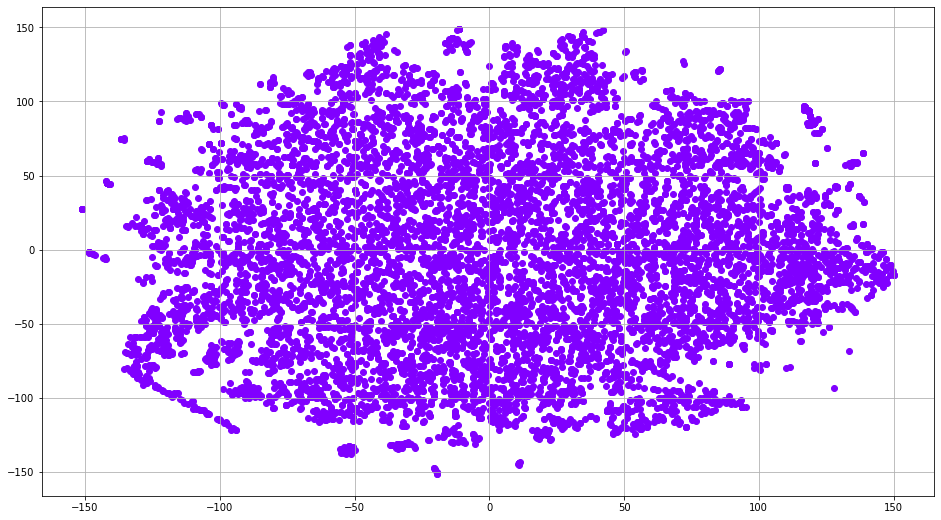

In [42]:
embed = embeddings[:10000]
plt.figure(figsize = (16, 9))
colors = cm.rainbow(np.linspace(0, 1, 1))
x = embed[:, 0]
y = embed[:, 1]
plt.scatter(x, y, c = colors)

plt.grid(True)
plt.show()

## 8. CLUSTERING

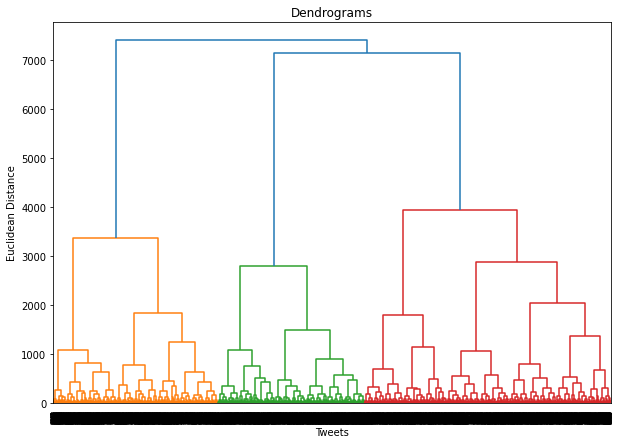

In [43]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize = (10, 7)) 
plt.title("Dendrograms")
dend = sch.dendrogram(sch.linkage(embed, method = 'ward'))
#plt.axhline(y = 1500, color = 'purple', linestyle = '--')
plt.xlabel('Tweets')
plt.ylabel('Euclidean Distance')
plt.show()

In [44]:
from sklearn.cluster import AgglomerativeClustering
    
cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')  
out = cluster.fit_predict(embed)

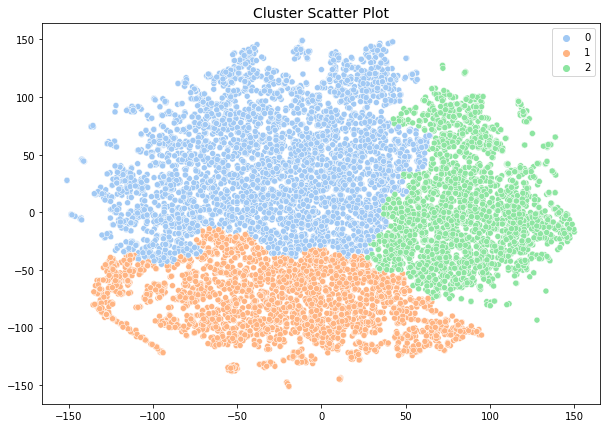

In [45]:
import seaborn as sns
plt.figure(figsize = (10, 7))
sns.scatterplot(x = embed[:, 0], y = embed[:, 1], hue = cluster.labels_, palette = 'pastel')
plt.title('Cluster Scatter Plot', fontsize = 14)
plt.show()

In [46]:
tweets_cluster = tweets.copy()

In [48]:
labels = cluster.labels_
for i, id_ in enumerate(t2v[:10000]):
    tweets_cluster.loc[tweets_cluster['id'] == id_, 'cluster'] = labels[i]

In [49]:
tweets_cluster.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,extended_entities,possibly_sensitive,withheld_in_countries,scopes,cluster
0,Sun Nov 22 10:54:27 +0000 2020,1330464657086275585,1330464657086275585,Respect @NIkosdN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,...,low,en,1606042467744,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,Sun Nov 22 10:54:27 +0000 2020,1330464657069531137,1330464657069531137,@TheJasonPugh Putting out the message that 🇨🇦 ...,"<a href=""http://twitter.com/download/android"" ...",True,1.330229e+18,1330229081368125444,4.571369e+08,457136882,...,low,en,1606042467740,"[14, 140]",{'full_text': '@TheJasonPugh Putting out the m...,NaN,NaN,NaN,NaN,0.0
2,Sun Nov 22 10:54:28 +0000 2020,1330464658650750978,1330464658650750978,@EleriTudor Boris Johnson gets to dictate how ...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,1.330464e+18,1330464495102283776,1.618683e+09,1618682941,...,low,en,1606042468117,"[12, 140]",{'full_text': '@EleriTudor Boris Johnson gets ...,NaN,NaN,NaN,NaN,1.0
3,Sun Nov 22 10:54:28 +0000 2020,1330464658235518977,1330464658235518977,#G20 #COVID19 is hitting every country in the ...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,None,...,low,en,1606042468018,"[0, 140]",{'full_text': '#G20 #COVID19 is hitting every ...,NaN,False,NaN,NaN,2.0
4,Sun Nov 22 10:54:28 +0000 2020,1330464658940112896,1330464658940112896,"500,000 Nigerians to benefit from the Payroll ...","<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,None,...,low,en,1606042468186,NaN,"{'full_text': '500,000 Nigerians to benefit fr...",NaN,False,NaN,NaN,0.0


In [50]:
tweets_cluster.tail()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,filter_level,lang,timestamp_ms,display_text_range,extended_tweet,extended_entities,possibly_sensitive,withheld_in_countries,scopes,cluster
36618,Sat Nov 21 17:37:44 +0000 2020,1330203757855055877,1330203757855055877,Be Kind\n\nBe kind to \nyour family. \nBe kind...,"<a href=""http://twitter.com/download/iphone"" r...",True,NaN,None,NaN,None,...,low,en,NaN,"[0, 140]",{'full_text': 'Be Kind Be kind to your famil...,NaN,False,NaN,NaN,NaN
36619,Thu Nov 19 20:59:26 +0000 2020,1329529739770535939,1329529739770535939,It’s time to start discussing a Covid strategy...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,None,...,low,en,NaN,"[0, 140]",{'full_text': 'It’s time to start discussing a...,NaN,False,NaN,NaN,NaN
36620,Sat Nov 21 22:21:14 +0000 2020,1330275103230267400,1330275103230267400,"Heavies in San Jose, Costa Rica (SJO) before a...","<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,...,low,en,NaN,"[0, 95]",NaN,"{'media': [{'id': 1330274863769149443, 'id_str...",False,NaN,NaN,NaN
36621,Sun Nov 22 05:49:41 +0000 2020,1330387958302695431,1330387958302695431,It's so unfortunate that the doctors who put t...,"<a href=""http://twitter.com/download/android"" ...",True,NaN,None,NaN,None,...,low,en,NaN,"[0, 140]",{'full_text': 'It's so unfortunate that the do...,NaN,False,NaN,NaN,NaN
36622,Sun Nov 15 14:40:57 +0000 2020,1327984940215009280,1327984940215009280,Thank you so much for showing everyone that ho...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,None,...,low,en,NaN,"[0, 140]",{'full_text': 'Thank you so much for showing e...,NaN,False,NaN,NaN,NaN


In [51]:
tweets_cluster.dropna(subset = ['cluster'], inplace = True)
tweets_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10021
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 10000 non-null  object 
 1   id                         10000 non-null  int64  
 2   id_str                     10000 non-null  object 
 3   text                       10000 non-null  object 
 4   source                     10000 non-null  object 
 5   truncated                  10000 non-null  bool   
 6   in_reply_to_status_id      3720 non-null   float64
 7   in_reply_to_status_id_str  3720 non-null   object 
 8   in_reply_to_user_id        4005 non-null   float64
 9   in_reply_to_user_id_str    4005 non-null   object 
 10  in_reply_to_screen_name    4005 non-null   object 
 11  user                       10000 non-null  object 
 12  geo                        8 non-null      object 
 13  coordinates                8 non-null      obj

In [52]:
tweets_cluster.to_csv("tweets_cluster.csv")

Get the cluster data

In [53]:
cluster0 = tweets_cluster[tweets_cluster['cluster'] == 0]
cluster1 = tweets_cluster[tweets_cluster['cluster'] == 1]
cluster2 = tweets_cluster[tweets_cluster['cluster'] == 2]

Amount of data per cluster

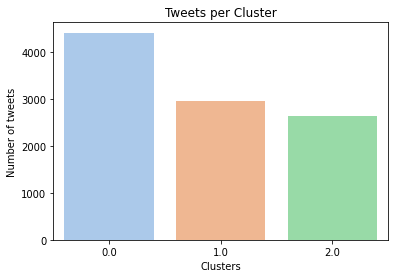

In [54]:
sns.countplot(x = 'cluster', data = tweets_cluster, palette = 'pastel')
plt.title('Tweets per Cluster')
plt.xlabel('Clusters')
plt.ylabel('Number of tweets')
plt.show()

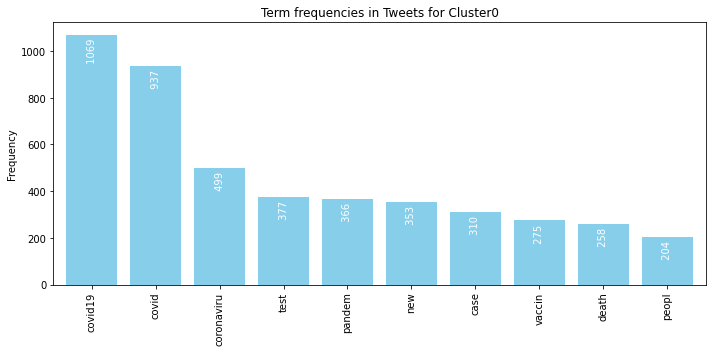

In [58]:
bag_of_words = {}

for text in cluster0["text"]:
     
    lst_text = getTerms(text)
    
    # create bag-of-words - for each word the frequency of the word in the corpus
    for word in lst_text:
        if word not in bag_of_words:
            bag_of_words[word] = 0
        bag_of_words[word] += 1
        
sorted_dict = {}
sorted_keys = sorted(bag_of_words, key = bag_of_words.get, reverse = True)

for w in sorted_keys:
    sorted_dict[w] = bag_of_words[w]
    
most_freq = 10
top = dict(list(sorted_dict.items())[:most_freq])

y = [count for tag, count in top.items()]
x = [tag for tag, count in top.items()]

plt.figure(figsize = (10, 5))
plt.bar(x, y, color = "skyblue")
plt.title("Term frequencies in Tweets for Cluster0")
plt.ylabel("Frequency")
plt.xticks(rotation = 90)
for i, tag in enumerate(top):
    plt.text(i, y[i], f" {y[i]} ", rotation = 90, ha = "center", va = "top" if i < 10 else "bottom", 
             color = "white" if i < 10 else "black")
plt.xlim(-0.6, len(x)-0.4) 
plt.tight_layout()
plt.show()

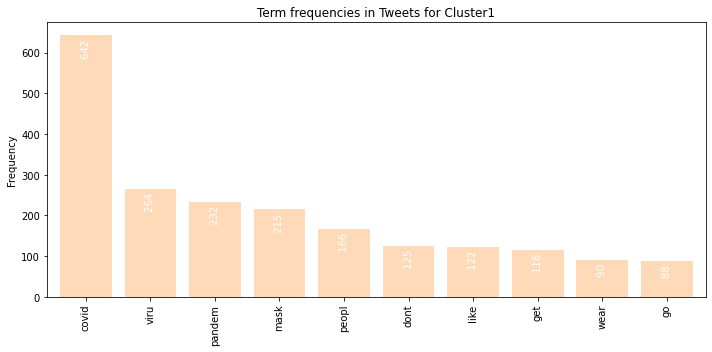

In [59]:
bag_of_words = {}

for text in cluster1["text"]:
     
    lst_text = getTerms(text)
    
    # create bag-of-words - for each word the frequency of the word in the corpus
    for word in lst_text:
        if word not in bag_of_words:
            bag_of_words[word] = 0
        bag_of_words[word] += 1
        
sorted_dict = {}
sorted_keys = sorted(bag_of_words, key = bag_of_words.get, reverse = True)

for w in sorted_keys:
    sorted_dict[w] = bag_of_words[w]
    
most_freq = 10
top = dict(list(sorted_dict.items())[:most_freq])

y = [count for tag, count in top.items()]
x = [tag for tag, count in top.items()]

plt.figure(figsize = (10, 5))
plt.bar(x, y, color = "peachpuff")
plt.title("Term frequencies in Tweets for Cluster1")
plt.ylabel("Frequency")
plt.xticks(rotation = 90)
for i, tag in enumerate(top):
    plt.text(i, y[i], f" {y[i]} ", rotation = 90, ha = "center", va = "top" if i < 10 else "bottom", 
             color = "white" if i < 10 else "black")
plt.xlim(-0.6, len(x)-0.4) 
plt.tight_layout()
plt.show()

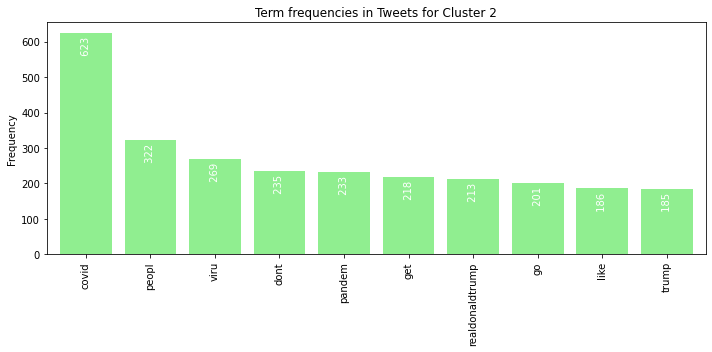

In [60]:
bag_of_words = {}

for text in cluster2["text"]:
     
    lst_text = getTerms(text)
    
    # create bag-of-words - for each word the frequency of the word in the corpus
    for word in lst_text:
        if word not in bag_of_words:
            bag_of_words[word] = 0
        bag_of_words[word] += 1
        
sorted_dict = {}
sorted_keys = sorted(bag_of_words, key = bag_of_words.get, reverse = True)

for w in sorted_keys:
    sorted_dict[w] = bag_of_words[w]
    
most_freq = 10
top = dict(list(sorted_dict.items())[:most_freq])

y = [count for tag, count in top.items()]
x = [tag for tag, count in top.items()]

plt.figure(figsize = (10, 5))
plt.bar(x, y, color = "lightgreen")
plt.title("Term frequencies in Tweets for Cluster 2")
plt.ylabel("Frequency")
plt.xticks(rotation = 90)
for i, tag in enumerate(top):
    plt.text(i, y[i], f" {y[i]} ", rotation = 90, ha = "center", va = "top" if i < 10 else "bottom", 
             color = "white" if i < 10 else "black")
plt.xlim(-0.6, len(x)-0.4) 
plt.tight_layout()
plt.show()